# Quantum state tomography
This notebook loosely follows through the examples in the [corresponding Qiskit tutorial](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/ignis/6a_state_tomography.ipynb).

In [1]:
# Matplotlib is recommended for Qiskit. Others are for fun.
import numpy as np
import qutip as qt
import matplotlib as plt
%matplotlib inline

from qiskit import *

# Load account (requires a saved IBMQ user id) and list available backends.
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
# Notebook widget for watching IBMQ jobs.
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

ibmqx2


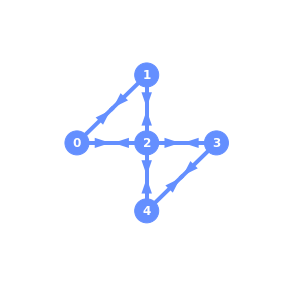

In [3]:
# Set least busy device as backend.
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_gate_map, plot_circuit_layout

small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
backend = least_busy(small_devices)

# Set qasm as simulator.
simulator = Aer.get_backend('qasm_simulator')

# Print name and configuration.
print(backend)
plot_gate_map(backend, plot_directed=True)

## Bell state

State preparation circuit.

In [4]:
# Quantum circuit for two-qubit bell state.
qr = QuantumRegister(5)
bell = QuantumCircuit(qr)
bell.h(0)
bell.cx(0, 1)
print(bell)

# Measurement circuit.
cr = ClassicalRegister(2)
meas = QuantumCircuit(qr, cr)
meas.barrier()
meas.measure([0,1], [0,1])
print(bell+meas)

         ┌───┐     
q0_0: |0>┤ H ├──■──
         └───┘┌─┴─┐
q0_1: |0>─────┤ X ├
              └───┘
q0_2: |0>──────────
                   
q0_3: |0>──────────
                   
q0_4: |0>──────────
                   
         ┌───┐      ░ ┌─┐   
q0_0: |0>┤ H ├──■───░─┤M├───
         └───┘┌─┴─┐ ░ └╥┘┌─┐
q0_1: |0>─────┤ X ├─░──╫─┤M├
              └───┘ ░  ║ └╥┘
q0_2: |0>───────────░──╫──╫─
                    ░  ║  ║ 
q0_3: |0>───────────░──╫──╫─
                    ░  ║  ║ 
q0_4: |0>───────────░──╫──╫─
                    ░  ║  ║ 
 c0_0: 0 ══════════════╩══╬═
                          ║ 
 c0_1: 0 ═════════════════╩═
                            


Testing the preparation circuit.

In [5]:
# Run bell circuit.
job = execute(bell+meas, backend, optimization_level=0, shots=5000)
print(job.job_id())

counts = job.result().get_counts()
print(counts)

# Simulate bell circuit.
counts_sim = execute(bell+meas, simulator, shots=5000).result().get_counts()

5e4265933fd01a0019d41c4b
{'00': 2072, '10': 111, '11': 2650, '01': 167}


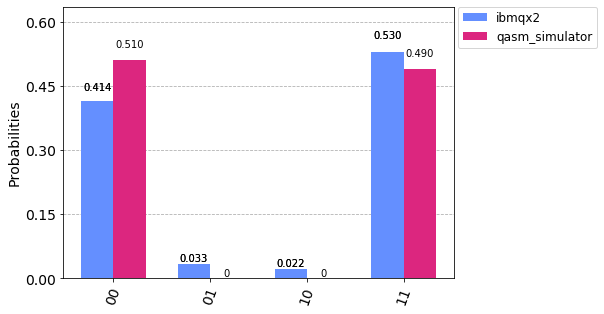

In [6]:
# Results from backend vs. simulator.
from qiskit.visualization import plot_histogram
plot_histogram([counts, counts_sim], legend = [backend, simulator])

Tomography driven by Qiskit.

In [7]:
# Calculate circuits for state tomography.
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
qst_bell = state_tomography_circuits(bell, [qr[0], qr[1]])

for circ in qst_bell:
    print(circ)

         ┌───┐      ░ ┌───┐┌─┐   
q0_0: |0>┤ H ├──■───░─┤ H ├┤M├───
         └───┘┌─┴─┐ ░ ├───┤└╥┘┌─┐
q0_1: |0>─────┤ X ├─░─┤ H ├─╫─┤M├
              └───┘ ░ └───┘ ║ └╥┘
q0_2: |0>───────────░───────╫──╫─
                    ░       ║  ║ 
q0_3: |0>───────────░───────╫──╫─
                    ░       ║  ║ 
q0_4: |0>───────────░───────╫──╫─
                    ░       ║  ║ 
 c1_0: 0 ═══════════════════╩══╬═
                               ║ 
 c1_1: 0 ══════════════════════╩═
                                 
         ┌───┐      ░  ┌───┐ ┌─┐        
q0_0: |0>┤ H ├──■───░──┤ H ├─┤M├────────
         └───┘┌─┴─┐ ░ ┌┴───┴┐└╥┘┌───┐┌─┐
q0_1: |0>─────┤ X ├─░─┤ Sdg ├─╫─┤ H ├┤M├
              └───┘ ░ └─────┘ ║ └───┘└╥┘
q0_2: |0>───────────░─────────╫───────╫─
                    ░         ║       ║ 
q0_3: |0>───────────░─────────╫───────╫─
                    ░         ║       ║ 
q0_4: |0>───────────░─────────╫───────╫─
                    ░         ║       ║ 
 c1_0: 0 ═════════════════════╩═══════╬

In [8]:
# Tomography circuits on backend.
job = execute(qst_bell, backend, optimization_level=0, shots=5000)
print(job.job_id())

5e4265bb8093f10018023f1f


0.8644837963593828


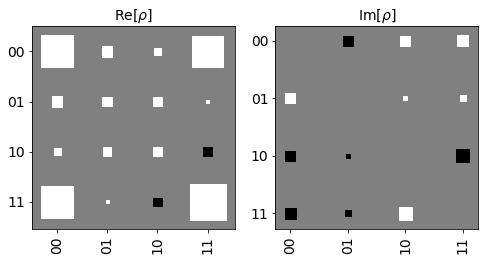

In [9]:
# Calculate density matrix.
tomo_bell = StateTomographyFitter(job.result(), qst_bell)
rho_bell = tomo_bell.fit()

# Calculate fidelity.
from qiskit.quantum_info import state_fidelity
psi_bell = execute(bell, Aer.get_backend('statevector_simulator')).result().get_statevector(bell)
print(state_fidelity(psi_bell[0:4], rho_bell))

# Hinton diagram of density matrix.
from qiskit.visualization import plot_state_hinton
plot_state_hinton(rho_bell)

## GHZ state

State preparation circuit.

In [10]:
# Quantum circuit for a five-qubit GHZ state.
qr = QuantumRegister(3)
ghz = QuantumCircuit(qr)
ghz.h(2)
for q in [0, 1]:
    ghz.cx(2, q)
print(ghz)

# Measurement circuit.
cr = ClassicalRegister(3)
meas = QuantumCircuit(qr, cr)
meas.barrier()
meas.measure(qr, cr)
print(ghz+meas)

              ┌───┐     
q1_0: |0>─────┤ X ├─────
              └─┬─┘┌───┐
q1_1: |0>───────┼──┤ X ├
         ┌───┐  │  └─┬─┘
q1_2: |0>┤ H ├──■────■──
         └───┘          
              ┌───┐      ░ ┌─┐      
q1_0: |0>─────┤ X ├──────░─┤M├──────
              └─┬─┘┌───┐ ░ └╥┘┌─┐   
q1_1: |0>───────┼──┤ X ├─░──╫─┤M├───
         ┌───┐  │  └─┬─┘ ░  ║ └╥┘┌─┐
q1_2: |0>┤ H ├──■────■───░──╫──╫─┤M├
         └───┘           ░  ║  ║ └╥┘
 c2_0: 0 ═══════════════════╩══╬══╬═
                               ║  ║ 
 c2_1: 0 ══════════════════════╩══╬═
                                  ║ 
 c2_2: 0 ═════════════════════════╩═
                                    


Testing the preparation circuit. 

In [11]:
# Run GHZ circuit.
job = execute(ghz+meas, backend, optimization_level=0, shots=5000)
print(job.job_id())

counts = job.result().get_counts()
print(counts)

# Simulate GHZ circuit.
counts_sim = execute(ghz+meas, simulator, shots=5000).result().get_counts()

5e42660bfe73cd0018194dba
{'000': 2573, '101': 126, '111': 2046, '010': 37, '110': 86, '100': 16, '001': 48, '011': 68}


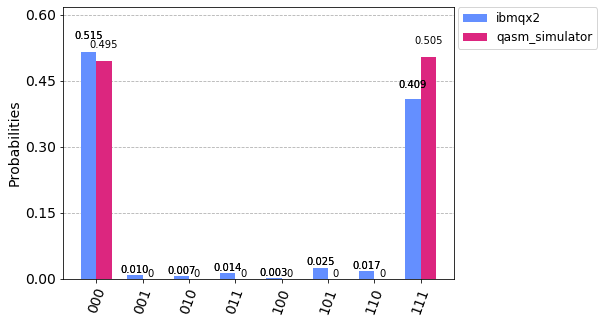

In [12]:
# Results from backend vs. simulator.
from qiskit.visualization import plot_histogram
plot_histogram([counts, counts_sim], legend = [backend, simulator])

Tomography driven by Qiskit.

In [13]:
# Calculate circuits for state tomography.
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
qst_ghz = state_tomography_circuits(ghz, qr)

for circ in qst_ghz:
    print(circ)

              ┌───┐      ░ ┌───┐┌─┐      
q1_0: |0>─────┤ X ├──────░─┤ H ├┤M├──────
              └─┬─┘┌───┐ ░ ├───┤└╥┘┌─┐   
q1_1: |0>───────┼──┤ X ├─░─┤ H ├─╫─┤M├───
         ┌───┐  │  └─┬─┘ ░ ├───┤ ║ └╥┘┌─┐
q1_2: |0>┤ H ├──■────■───░─┤ H ├─╫──╫─┤M├
         └───┘           ░ └───┘ ║  ║ └╥┘
 c3_0: 0 ════════════════════════╩══╬══╬═
                                    ║  ║ 
 c3_1: 0 ═══════════════════════════╩══╬═
                                       ║ 
 c3_2: 0 ══════════════════════════════╩═
                                         
              ┌───┐      ░  ┌───┐ ┌─┐           
q1_0: |0>─────┤ X ├──────░──┤ H ├─┤M├───────────
              └─┬─┘┌───┐ ░  ├───┤ └╥┘┌─┐        
q1_1: |0>───────┼──┤ X ├─░──┤ H ├──╫─┤M├────────
         ┌───┐  │  └─┬─┘ ░ ┌┴───┴┐ ║ └╥┘┌───┐┌─┐
q1_2: |0>┤ H ├──■────■───░─┤ Sdg ├─╫──╫─┤ H ├┤M├
         └───┘           ░ └─────┘ ║  ║ └───┘└╥┘
 c3_0: 0 ══════════════════════════╩══╬═══════╬═
                                      ║       ║ 
 c3_1: 0 ════

In [14]:
# Tomography circuits on backend.
job = execute(qst_ghz, backend, optimization_level=0, shots=5000)
print(job.job_id())

5e42671ab6394e0018d4e970


0.788916726957782


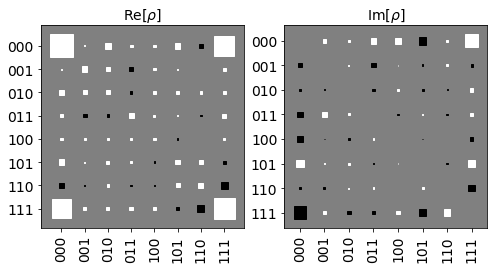

In [15]:
# Calculate density matrix.
tomo_ghz = StateTomographyFitter(job.result(), qst_ghz)
rho_ghz = tomo_ghz.fit()

# Calculate fidelity.
from qiskit.quantum_info import state_fidelity
psi_ghz = execute(ghz, Aer.get_backend('statevector_simulator')).result().get_statevector(ghz)
print(state_fidelity(psi_ghz[0:8], rho_ghz))

# Hinton diagram of density matrix.
from qiskit.visualization import plot_state_hinton
plot_state_hinton(rho_ghz)